# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# Package import

In [2]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, mean_squared_error, explained_variance_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn import preprocessing
% matplotlib inline
pd.options.mode.chained_assignment = None 
pd.set_option("display.max_columns", None)

# Data Understanding and basic cleaning

In [7]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### About the portfolio dataset
* It is a 10 * 6 shaped dataset.
* We have 4 entries for bogo, 4 entries for discount and 2 entries for informational.
* The difficulty and reward for informational offer are both 0.
* In average, compared to discount, bogo has lower difficulty and higher reward. 

In [8]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [9]:
# look into the portfolio dataset
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [10]:
# shape of dataset
portfolio.shape

(10, 6)

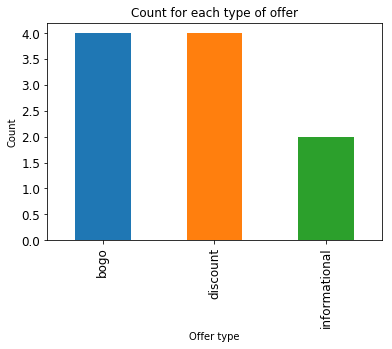

In [11]:
# counts for each type of offer
portfolio['offer_type'].value_counts().plot.bar(fontsize = 12)
plt.title('Count for each type of offer')
plt.xlabel('Offer type')
plt.ylabel('Count')
plt.show()

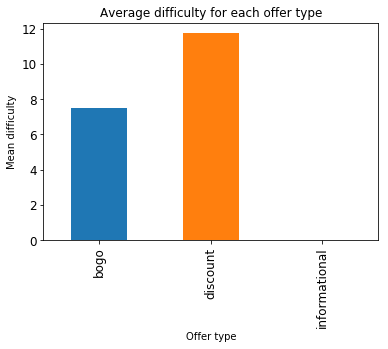

In [12]:
# difficulty information
portfolio.groupby('offer_type')['difficulty'].mean().plot.bar(fontsize = 12)
plt.title('Average difficulty for each offer type')
plt.xlabel('Offer type')
plt.ylabel('Mean difficulty')
plt.show()

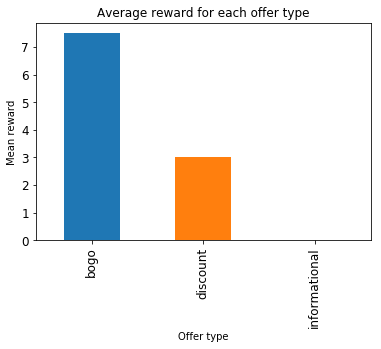

In [13]:
# reward information
portfolio.groupby('offer_type')['reward'].mean().plot.bar(fontsize = 12)
plt.title('Average reward for each offer type')
plt.xlabel('Offer type')
plt.ylabel('Mean reward')
plt.show()

### Clean the portfolio data 
* Change column name for further analysis
* Dummy coding the offer type column and the channels column, then replace the original columns

In [14]:
def clean_portfolio():
    '''This is for clean the portfolio dataset'''
    global portfolio
    offertype_df = pd.get_dummies(portfolio['offer_type'])
    mlb = MultiLabelBinarizer()
    channels_df = pd.DataFrame(mlb.fit_transform(portfolio['channels']),columns=mlb.classes_, index=portfolio.index)
    portfolio = pd.concat([portfolio, offertype_df, channels_df], axis = 1)
    portfolio = portfolio.drop(['channels', 'offer_type'], axis = 1)
    portfolio.rename(columns={'id':'offer_id'}, inplace = True)
    return portfolio

In [15]:
portfolio = clean_portfolio()
portfolio.head()

,difficulty,duration,offer_id,reward,bogo,discount,informational,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0,1


### About the profile dataset
* A 14825 * 5 shaped dataset.
* From the age distribution plot, most of the users are around 45 - 65 years old. 
* From the income distribution plot, most of the users have incomes between 50k - 70k.
* We have around 8k male in the dataset while around 6k for female. 

#### Clean the profile dataset
* Drop unreasonable data points 
* Dummy encode the year that the user became a member on, and drop the original column
* Dummy encode gender and replace the original one 

In [16]:
profile.head(20)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [17]:
profile.shape

(17000, 5)

We can see that there are missing values in the gender and income column. The number of missing values are the same, both 2175. From the head of the dataset, we can observe that there are entries with age being 118, none gender and null income. These must be mistakes and will not be useful in further analysis. So, we can remove them.

In [18]:
profile.isnull().sum(axis = 0)

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [19]:
# remove rows with age == 118
profile = profile[profile['age']!=118]

In [20]:
# Then we check missing values again
profile.isnull().sum(axis = 0)

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

All the missing values are gone. We can do some further data understanding now. 

In [21]:
profile.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [22]:
profile.describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [23]:
profile.shape

(14825, 5)

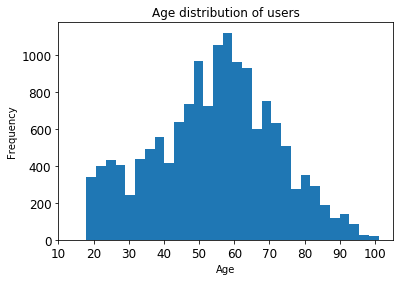

In [24]:
# age distribution
profile['age'].plot.hist(bins=30, fontsize = 12)
plt.xticks(range(10, 110, 10))
plt.title('Age distribution of users')
plt.xlabel('Age')
plt.show()

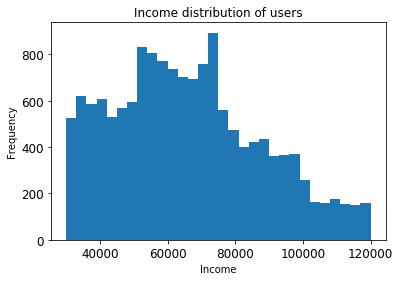

In [25]:
# income distribution
profile['income'].plot.hist(bins=30, fontsize = 12)
plt.title('Income distribution of users')
plt.xlabel('Income')
plt.show()

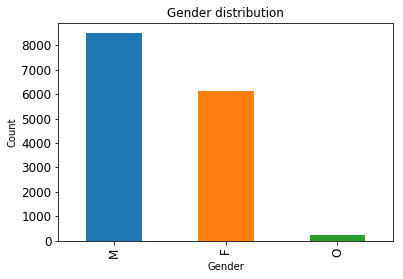

In [26]:
# sex distribution 
profile['gender'].value_counts().plot.bar(fontsize = 12)
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [27]:
# Dummy encode the year 
def get_year(date):
    '''get the year from a date string'''
    sdate = datetime.datetime.strptime(str(date), '%Y%m%d')
    return sdate.year
def clean_profile():
    '''For cleaning the profile dataset'''
    global profile
    year_df = pd.get_dummies(profile['became_member_on'].apply(get_year))
    gender_df = pd.get_dummies(profile['gender'])
    profile = pd.concat([profile, year_df, gender_df], axis=1)
    profile = profile.drop(['became_member_on', 'gender'], axis = 1)
    profile.rename(columns={'id':'user_id'}, inplace=True)
    return profile

In [28]:
profile = clean_profile()
profile.head()

,age,user_id,income,2013,2014,2015,2016,2017,2018,F,M,O
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,1,0,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,1,0,1,0,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,0,0,1,0,1,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,0,0,1,0,1,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,1,0,0,1,0


In [29]:
profile.shape

(14825, 12)

### About the transcript dataset
* A 306534 * 4 shaped dataset.
* This dataset contains multiple classes of offer and transaction informations. 
* A customer could have multiple entries about receiving, viewing and completing offers, as well as the transaction information. 
* Ordered by time, if we see patterns like: 'offer received' - 'offer viewed' - 'transaction' - 'offer completed', this means that the offer works.

In [30]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [31]:
# check missing value
transcript.isnull().sum(axis = 0)

event     0
person    0
time      0
value     0
dtype: int64

In [32]:
transcript.shape

(306534, 4)

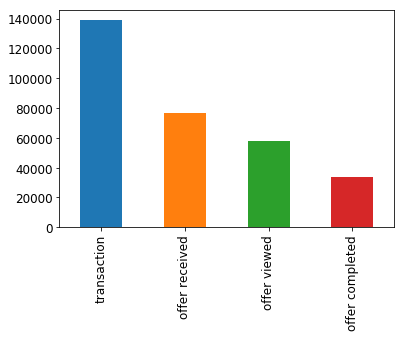

In [33]:
# event distribution
transcript['event'].value_counts().plot.bar(fontsize = 12)

In [34]:
# offer received class
transcript[transcript['event'] == 'offer received'].head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [35]:
# offer viewed class
transcript[transcript['event'] == 'offer viewed'].head()

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [36]:
# offer completed class
transcript[transcript['event'] == 'offer completed'].head()

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [37]:
# transaction class
transcript[transcript['event'] == 'transaction'].head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [38]:
# pick a random customer to understand 
transcript[transcript['person'] == '54890f68699049c2a04d415abc25e717']

,event,person,time,value
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
36917,transaction,54890f68699049c2a04d415abc25e717,78,{'amount': 21.35}
59408,offer received,54890f68699049c2a04d415abc25e717,168,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
74810,offer viewed,54890f68699049c2a04d415abc25e717,186,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
109893,transaction,54890f68699049c2a04d415abc25e717,330,{'amount': 15.61}
109894,offer completed,54890f68699049c2a04d415abc25e717,330,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
117069,offer received,54890f68699049c2a04d415abc25e717,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
145383,transaction,54890f68699049c2a04d415abc25e717,390,{'amount': 22.39}
145384,offer completed,54890f68699049c2a04d415abc25e717,390,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...
156869,offer received,54890f68699049c2a04d415abc25e717,408,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


#### Clean the transcript dataset
* Dummy encoding the event column
* Expand the value column for different event type 
* Change the unit of time from hours to days

In [39]:
def clean_transcript():
    global transcript
    # expand the value column
    transcript = transcript.join(pd.DataFrame.from_records(transcript.pop('value')))
    # combine the offer id column
    transcript.offer_id.update(transcript.pop('offer id'))
    # change time unit 
    transcript['time'] = transcript['time'] / 24
    # rename person column
    transcript.rename(columns={'person':'user_id', 'reward': 'comp_reward'}, inplace=True)
    # sort values 
    transcript.sort_values(['user_id', 'time'], inplace=True)
    # drop the users that are not in the profile data set (some are excluded because of unreasonable age before)
    transcript = transcript.loc[transcript['user_id'].isin(profile['user_id'].unique())]
    return transcript

In [40]:
transcript = clean_transcript()

### Combine the three dataset 

In [41]:
transcript.head()

,event,user_id,time,amount,offer_id,comp_reward
55972,offer received,0009655768c64bdeb2e877511632db8f,7.0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
77705,offer viewed,0009655768c64bdeb2e877511632db8f,8.0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
89291,transaction,0009655768c64bdeb2e877511632db8f,9.5,22.16,NaN,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,14.0,NaN,3f207df678b143eea3cee63160fa8bed,NaN
139992,offer viewed,0009655768c64bdeb2e877511632db8f,15.5,NaN,3f207df678b143eea3cee63160fa8bed,NaN


In [42]:
# This is for finding indicator for each categories
received_ind = (transcript.event == 'offer received')
viewed_ind = (transcript.event == 'offer viewed')
completed_ind = (transcript.event == 'offer completed')
transaction_ind = (transcript.event == 'transaction')

In [43]:
def add_col(transcript):
    '''This is for adding new columns to the transcript dataset, which are useful for further analysis'''
    transcript['offer_viewed'] = 0
    transcript['offer_completed'] = 0
    transcript['viewed_before_completed'] = 0
    transcript['trans_amount_comp'] = 0
    transcript['reward_amount'] = 0
    transcript['total_trans_amount'] = 0
add_col(transcript)

In [44]:
transcript.head()

,event,user_id,time,amount,offer_id,comp_reward,offer_viewed,offer_completed,viewed_before_completed,trans_amount_comp,reward_amount,total_trans_amount
55972,offer received,0009655768c64bdeb2e877511632db8f,7.0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0,0,0,0,0,0
77705,offer viewed,0009655768c64bdeb2e877511632db8f,8.0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0,0,0,0,0,0
89291,transaction,0009655768c64bdeb2e877511632db8f,9.5,22.16,NaN,NaN,0,0,0,0,0,0
113605,offer received,0009655768c64bdeb2e877511632db8f,14.0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0,0,0,0,0,0
139992,offer viewed,0009655768c64bdeb2e877511632db8f,15.5,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0,0,0,0,0,0


We need to clean the transcript data set further to dig out information about valid offers. There are multiple requirements to meet if we want to treat an offer as a valid one: 
* User needs to view the offer, within the valid time window. 
* User needs to make transactions with at least the amount that is required by the offer, within the valid time window.

I will create indicators for each received offer to show the status of it:

*offer_viewed* : 1 if a received offer is viewed later; otherwise 0.

*offer_completed* : 1 if a received offer is completed later; otherwise 0. Note: an offer can be completed without being viewed.

*viewed_before_completed* : 1 if a received offer is first viewed then completed; 0 otherwise. This indicator tells if an offer really worked.

I will also create some variables to store numeric values that we can look into later:

*trans_amount_comp* : The total transaction amount between the start of the offer till the completion of the offer.

*reward_amount* : The reward amount of the offer.

*total_trans_amount* : The total transaction amount between the start of the offer till the end of the offer.

In [45]:
# Create a dictionary to easily find offer duration with offer id 
offerDurations = dict(zip(portfolio.offer_id,portfolio.duration))

for i in profile.index:
    person = profile.user_id[i]
    person_ind = (transcript['user_id'] == person)  
    
    # get indices for each category. With the indices, we can subset the original dataset
    received_indices = transcript.index[person_ind & received_ind]
    viewed_indices = transcript.index[person_ind & viewed_ind]
    completed_indices = transcript.index[person_ind & completed_ind]
    transaction_indices = transcript.index[person_ind & transaction_ind]

    # get the ids and times of the offers received 
    received_ids = transcript['offer_id'][received_indices].values
    received_times = transcript['time'][received_indices].values

    # Get the expiration time for each offer 
    duration_times = [offerDurations[x] for x in received_ids]
    receivedEnd_times = received_times + duration_times

    # get the ids and times of the offers that are viewed. These must be a subset of received offers 
    viewed_ids = transcript['offer_id'][viewed_indices].values
    viewed_times = transcript['time'][viewed_indices].values
    
    # get the ids and times of the offers completed. Notice that an offer can be completed without being viewed    
    completed_ids = transcript['offer_id'][completed_indices].values
    completed_times = transcript['time'][completed_indices].values
    completed_rewards = transcript['comp_reward'][completed_indices].values

    # get the amount and times of each transaction
    transaction_amounts = transcript['amount'][transaction_indices].values
    transaction_times = transcript['time'][transaction_indices].values

    for j, offerid in enumerate(received_ids):

        # get time points of the start and end of an offer, transaction outside of this time period does not count 
        offerBegin = received_times[j]
        offerEnd = receivedEnd_times[j]
 
        # for each offer, find transactions during the period that the offer is active 
        offerTrans_mask = (transaction_times >= offerBegin) & (transaction_times <= offerEnd)
        transcript.loc[received_indices[j],'total_trans_amount'] = sum(transaction_amounts[offerTrans_mask])

        # check if an offer is viewed
        if (offerid in viewed_ids):
            view_mask = (viewed_ids == offerid) & (viewed_times >= offerBegin) & (viewed_times <= offerEnd)
            if sum(view_mask) > 0:
                transcript.loc[received_indices[j],'offer_viewed'] = 1

        # Check if an offer is completed
        if (offerid in completed_ids):
            compOffer_mask = (completed_ids == offerid) & (completed_times >= offerBegin) & (completed_times <= offerEnd)
            # If an offer was completed
            if sum(compOffer_mask) > 0:
                # Get reward ammount and time for completed offer
                compOfferReward = completed_rewards[compOffer_mask][0]
                compOfferTime = completed_times[compOffer_mask][0]
                # Mark the the received offer was completed in the transcript data set
                transcript.loc[received_indices[j],'offer_completed'] = 1
                # Record reward of completed offer
                transcript.loc[received_indices[j],'reward_amount'] = compOfferReward
                # Find trans amount during valid offer period
                compTrans_mask = (transaction_times >= offerBegin) & (transaction_times <= compOfferTime)
                compTrans = transaction_amounts[compTrans_mask]
                transcript.loc[received_indices[j],'trans_amount_comp'] = sum(compTrans)

            # find out if an offer is viewed before completed
            if (offerid in viewed_ids):
                compView_mask = (viewed_ids == offerid) & (viewed_times >= offerBegin) & (viewed_times <= compOfferTime)
                if sum(compView_mask) > 0:
                    transcript.loc[received_indices[j],'viewed_before_completed'] = sum(compView_mask)

1000 is done
2000 is done
3000 is done
4000 is done
5000 is done
6000 is done
7000 is done
8000 is done
9000 is done
10000 is done
11000 is done
13000 is done
14000 is done
15000 is done
16000 is done


In [46]:
transcript.head()

,event,user_id,time,amount,offer_id,comp_reward,offer_viewed,offer_completed,viewed_before_completed,trans_amount_comp,reward_amount,total_trans_amount
55972,offer received,0009655768c64bdeb2e877511632db8f,7.0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,1,0,0,0.0,0.0,22.16
77705,offer viewed,0009655768c64bdeb2e877511632db8f,8.0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0,0,0,0.0,0.0,0.00
89291,transaction,0009655768c64bdeb2e877511632db8f,9.5,22.16,NaN,NaN,0,0,0,0.0,0.0,0.00
113605,offer received,0009655768c64bdeb2e877511632db8f,14.0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,1,0,0,0.0,0.0,8.57
139992,offer viewed,0009655768c64bdeb2e877511632db8f,15.5,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0,0,0,0.0,0.0,0.00


In [47]:
# merge the transcript data set with the portfolio and profile data set
trans = transcript.merge(portfolio, how = 'left', on = 'offer_id').merge(profile, how = 'left', on = 'user_id')

In [63]:
# store for further use
#with open('trans.pickle', 'wb') as op:
#    pickle.dump(trans, op)

In [3]:
# get data
#with open('trans.pickle', 'rb') as data:
#    trans = pickle.load(data)

In [4]:
# subset to only contain rows with 'offer_received' type 
rec_of = trans[trans['event'] == 'offer received']
# drop useless columns
rec_of.drop(axis=1, columns=['amount', 'comp_reward', 'event'], inplace=True)

In [5]:
rec_of.head()

,user_id,time,offer_id,offer_viewed,offer_completed,viewed_before_completed,trans_amount_comp,reward_amount,total_trans_amount,difficulty,duration,reward,bogo,discount,informational,email,mobile,social,web,age,income,2013,2014,2015,2016,2017,2018,F,M,O
0,0009655768c64bdeb2e877511632db8f,7.0,5a8bc65990b245e5a138643cd4eb9837,1,0,0,0.00,0.0,22.16,0.0,3.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,33,72000.0,0,0,0,0,1,0,0,1,0
3,0009655768c64bdeb2e877511632db8f,14.0,3f207df678b143eea3cee63160fa8bed,1,0,0,0.00,0.0,8.57,0.0,4.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,33,72000.0,0,0,0,0,1,0,0,1,0
5,0009655768c64bdeb2e877511632db8f,17.0,f19421c1d4aa40978ebb69ca19b0e20d,1,1,0,8.57,5.0,22.68,5.0,5.0,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,33,72000.0,0,0,0,0,1,0,0,1,0
9,0009655768c64bdeb2e877511632db8f,21.0,fafdcd668e3743c1bb461111dcafc2a4,1,1,0,14.11,2.0,96.87,10.0,10.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,33,72000.0,0,0,0,0,1,0,0,1,0
14,0009655768c64bdeb2e877511632db8f,24.0,2906b810c7d4411798c6938adc9daaa5,0,1,0,10.27,2.0,69.20,10.0,7.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,33,72000.0,0,0,0,0,1,0,0,1,0


### Exploratory Data Analysis

In [7]:
# proportion of viewed offer and completed offer 
print('The proportion of viewed offer is', round(rec_of['offer_viewed'].mean(),3))
print('The proportion of completed offer is', round(rec_of['offer_completed'].mean(),3))

The proportion of viewed offer is 0.739
The proportion of completed offer is 0.488


From the two plot below, we can observe some fun facts:
* In successful offers, 2USD, 3USD, 5USD and 10USD offers share similar proportions.
* The 3USD offer were provided in least amount. However, in successful offers, its proportion is relatively high. We can see this is a reward amount that have potential. 

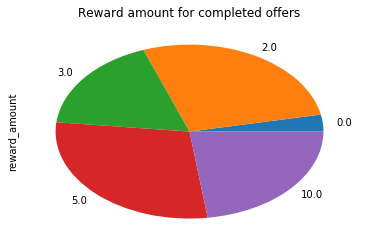

In [20]:
# for those completed offers, what does the reward distribution look like
rec_of[rec_of['viewed_before_completed']>0].reward_amount.value_counts().sort_index().plot.pie()
plt.title('Reward amount for completed offers')
plt.show()

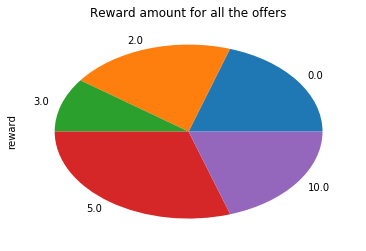

In [21]:
# for all the offers that have a reward, what does the reward distribution look like, regardless it is completed or not
rec_of.reward.value_counts().sort_index().plot.pie()
plt.title('Reward amount for all the offers')
plt.show()

From the plot below, we can see that the transaction amount peaked around 18USD among successful offers.

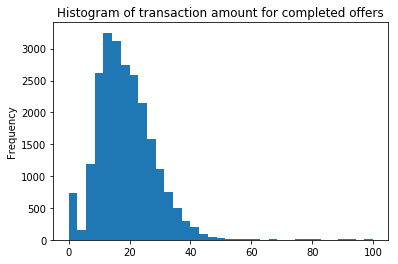

In [22]:
# for those completed offers, what does the transaction amount distribution look like
rec_of[rec_of['viewed_before_completed']>0].trans_amount_comp.plot.hist(range = (0,100), bins = 35)
plt.title('Histogram of transaction amount for completed offers')
plt.show()

From the plot below, we can observe that those who complete an offer mostly are between 50 to 70.

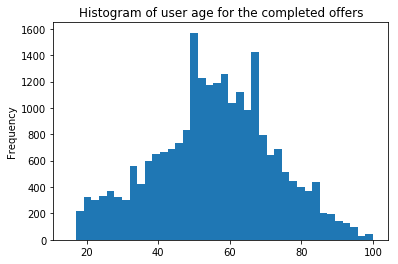

In [23]:
# age distribution for those who completes an offer
rec_of[rec_of['viewed_before_completed']>0].age.plot.hist(range = (15,100), bins = 40)
plt.title('Histogram of user age for the completed offers')
plt.show()

From the plot below, we can see that most customers who complete an offer have income mostly between 50k to 70k.

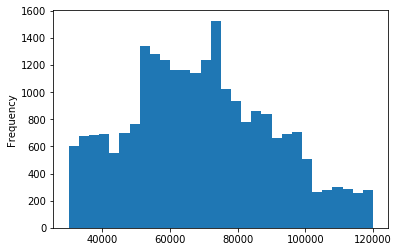

In [13]:
# income distribution for those who completes an offer
rec_of[rec_of['viewed_before_completed']>0].income.plot.hist(bins = 30)
plt.title('Histogram of user income for completed offers')
plt.show()

We can see that compared to baseline, the social channel type has the potential since its proportion among all types increases.

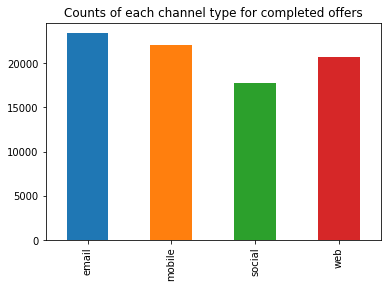

In [24]:
# for completed offer, email social or web, which is better?
rec_of[rec_of['viewed_before_completed']>0].loc[:,('email', 'mobile', 'social', 'web')].sum(axis = 0).plot.bar()
plt.title('Counts of each channel type for completed offers')
plt.show()

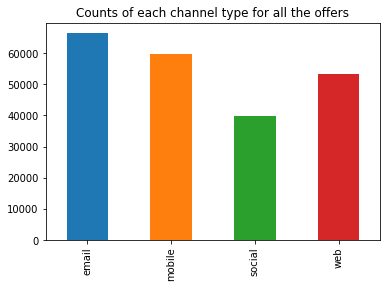

In [25]:
# Baseline
rec_of.loc[:,('email', 'mobile', 'social', 'web')].sum(axis = 0).plot.bar()
plt.title('Counts of each channel type for all the offers')
plt.show()

We can see that compared to baseline, the 7USD difficulty offer has the potential since its proportion increases in completed offers, while the 20USD difficulty offer may not be so popular.

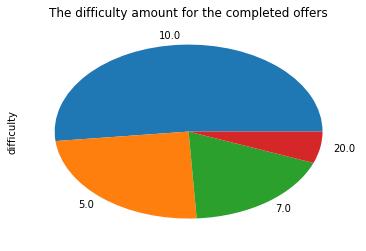

In [27]:
# for completed offer, difficulty distribution 
rec_of[rec_of['viewed_before_completed']>0].difficulty.value_counts().plot.pie()
plt.title('The difficulty amount for the completed offers')
plt.show()

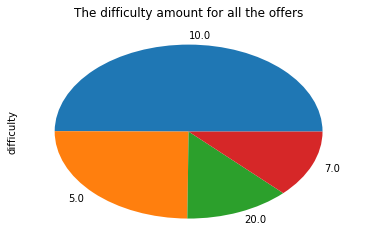

In [26]:
#baseline
rec_of[rec_of['difficulty']!=0].difficulty.value_counts().plot.pie()
plt.title('The difficulty amount for all the offers')
plt.show()

# Build Model 

## Part 1: Offer complete prediction 


I want to use predictors I have to predict if an offer would be completed. Multiplt machine learning methods will be used and compared. 

### Data set preparation 

In [5]:
rec_of.head()

,user_id,time,offer_id,offer_viewed,offer_completed,viewed_before_completed,trans_amount_comp,reward_amount,total_trans_amount,difficulty,duration,reward,bogo,discount,informational,email,mobile,social,web,age,income,2013,2014,2015,2016,2017,2018,F,M,O
0,0009655768c64bdeb2e877511632db8f,7.0,5a8bc65990b245e5a138643cd4eb9837,1,0,0,0.00,0.0,22.16,0.0,3.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,33,72000.0,0,0,0,0,1,0,0,1,0
3,0009655768c64bdeb2e877511632db8f,14.0,3f207df678b143eea3cee63160fa8bed,1,0,0,0.00,0.0,8.57,0.0,4.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,33,72000.0,0,0,0,0,1,0,0,1,0
5,0009655768c64bdeb2e877511632db8f,17.0,f19421c1d4aa40978ebb69ca19b0e20d,1,1,0,8.57,5.0,22.68,5.0,5.0,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,33,72000.0,0,0,0,0,1,0,0,1,0
9,0009655768c64bdeb2e877511632db8f,21.0,fafdcd668e3743c1bb461111dcafc2a4,1,1,0,14.11,2.0,96.87,10.0,10.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,33,72000.0,0,0,0,0,1,0,0,1,0
14,0009655768c64bdeb2e877511632db8f,24.0,2906b810c7d4411798c6938adc9daaa5,0,1,0,10.27,2.0,69.20,10.0,7.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,33,72000.0,0,0,0,0,1,0,0,1,0


In [6]:
y = [0 if i == 0 else 1 for i in rec_of['viewed_before_completed']]

In [7]:
col_name = ['trans_amount_comp','total_trans_amount','difficulty',
            'duration','reward','bogo','discount',
            'informational','email','mobile','social','web','age',
            'income',2013,2014,2015,2016,2017,2018,'F','M','O']
X = rec_of[col_name]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 77)

### Random Forest

In [26]:
# train model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
# make prediction 
y_pred_untune = rf_model.predict(X_test)

In [28]:
# confusion matrix
confusion_matrix(y_test, y_pred_untune)

array([[7619, 1057],
       [ 992, 3633]])

In [29]:
print('Precision: %.3f' % precision_score(y_test, y_pred_untune))
print('Recall: %.3f' % recall_score(y_test, y_pred_untune))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_untune))
print('F1 Score: %.3f' % f1_score(y_test, y_pred_untune))

Precision: 0.775
Recall: 0.786
Accuracy: 0.846
F1 Score: 0.780


#### Model tuning

In [12]:
# Number of trees in random forest
n_estimators = [100, 300, 500, 800, 1200, 1500, 2000]
# Maximum number of levels in tree
max_depth = [2,4,6,8,10,15,20]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 30, 50]
max_features = ['auto', 'sqrt']
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'max_features': max_features}

In [13]:
rf_base = RandomForestClassifier(criterion = 'gini')
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 30, cv = 4,
                               verbose=2,
                               random_state=77, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[CV] n_estimators=500, min_samples_split=10, max_features=sqrt, max_depth=2 
[CV]  n_estimators=500, min_samples_split=10, max_features=sqrt, max_depth=2, total=  13.7s
[CV] n_estimators=500, min_samples_split=10, max_features=sqrt, max_depth=2 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   16.7s remaining:    0.0s


[CV]  n_estimators=500, min_samples_split=10, max_features=sqrt, max_depth=2, total=  13.3s
[CV] n_estimators=500, min_samples_split=10, max_features=sqrt, max_depth=2 
[CV]  n_estimators=500, min_samples_split=10, max_features=sqrt, max_depth=2, total=  13.3s
[CV] n_estimators=500, min_samples_split=10, max_features=sqrt, max_depth=2 
[CV]  n_estimators=500, min_samples_split=10, max_features=sqrt, max_depth=2, total=   6.1s
[CV] n_estimators=2000, min_samples_split=50, max_features=auto, max_depth=6 
[CV]  n_estimators=2000, min_samples_split=50, max_features=auto, max_depth=6, total=  44.1s
[CV] n_estimators=2000, min_samples_split=50, max_features=auto, max_depth=6 
[CV]  n_estimators=2000, min_samples_split=50, max_features=auto, max_depth=6, total=  44.4s
[CV] n_estimators=2000, min_samples_split=50, max_features=auto, max_depth=6 
[CV]  n_estimators=2000, min_samples_split=50, max_features=auto, max_depth=6, total=  43.7s
[CV] n_estimators=2000, min_samples_split=50, max_feature

[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 74.9min finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=30, n_jobs=-1,
          param_distributions={'n_estimators': [100, 300, 500, 800, 1200, 1500, 2000], 'max_depth': [2, 4, 6, 8, 10, 15, 20], 'min_samples_split': [2, 5, 10, 15, 20, 30, 50], 'max_features': ['auto', 'sqrt']},
          pre_dispatch='2*n_jobs', random_state=77, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [14]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 20,
 'max_features': 'sqrt',
 'max_depth': 15}

In [16]:
param_grid = {
    'n_estimators': [500, 800, 1000],
    'max_depth': [12, 15, 18],
    'min_samples_split': [15, 20, 25, 30]
}

In [17]:
# Base model
rf_grid = RandomForestClassifier(criterion = 'gini', max_features = 'sqrt')
# Instantiate the grid search model
grid_rf_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = 4, n_jobs = -1, verbose = 2)
grid_rf_search.fit(X_train, y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
[CV] max_depth=12, min_samples_split=15, n_estimators=500 ............
[CV]  max_depth=12, min_samples_split=15, n_estimators=500, total=  17.5s
[CV] max_depth=12, min_samples_split=15, n_estimators=500 ............


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.9s remaining:    0.0s


[CV]  max_depth=12, min_samples_split=15, n_estimators=500, total=  17.7s
[CV] max_depth=12, min_samples_split=15, n_estimators=500 ............
[CV]  max_depth=12, min_samples_split=15, n_estimators=500, total=  17.1s
[CV] max_depth=12, min_samples_split=15, n_estimators=500 ............
[CV]  max_depth=12, min_samples_split=15, n_estimators=500, total=  17.6s
[CV] max_depth=12, min_samples_split=15, n_estimators=800 ............
[CV]  max_depth=12, min_samples_split=15, n_estimators=800, total=  27.9s
[CV] max_depth=12, min_samples_split=15, n_estimators=800 ............
[CV]  max_depth=12, min_samples_split=15, n_estimators=800, total=  27.8s
[CV] max_depth=12, min_samples_split=15, n_estimators=800 ............
[CV]  max_depth=12, min_samples_split=15, n_estimators=800, total=  27.7s
[CV] max_depth=12, min_samples_split=15, n_estimators=800 ............
[CV]  max_depth=12, min_samples_split=15, n_estimators=800, total=  27.3s
[CV] max_depth=12, min_samples_split=15, n_estimators=10

[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 80.1min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [500, 800, 1000], 'max_depth': [12, 15, 18], 'min_samples_split': [15, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [18]:
grid_rf_search.best_params_

{'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 500}

In [19]:
# get the best params grid
best_rf_grid = grid_rf_search.best_estimator_
best_rf_grid

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
# confusion matrix
y_pred = grid_rf_search.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[7485, 1191],
       [ 603, 4022]])

In [43]:
# metrics
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

Precision: 0.772
Recall: 0.870
Accuracy: 0.865
F1 Score: 0.818


In [48]:
rf_met = pd.DataFrame([{'precision':precision_score(y_test, y_pred),'recall':recall_score(y_test, y_pred),
  'accuracy':accuracy_score(y_test, y_pred),'F1 Score':f1_score(y_test, y_pred)}],index = ['Random Forest'])

In [25]:
# feature importance
pd.DataFrame(best_rf_grid.feature_importances_, index=X_train.columns).sort_values(by = 0, ascending=False)

,0
trans_amount_comp,0.395914
total_trans_amount,0.229472
social,0.057035
difficulty,0.053886
duration,0.052493
reward,0.044034
informational,0.042287
income,0.036748
age,0.028082
mobile,0.012646


### KNN

In [34]:
# Determine the optimal number of neighbors
neighbors = np.arange(1, 30)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
 
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
     
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)


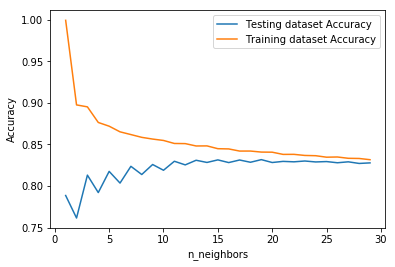

In [36]:
# plot the 'accuracy ~ number of neighbors' plot  
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
 
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

From the plot, we can see that the accuracy of test set stops increasing after K = 15. We pick it as out parameter.

In [49]:
knn_model = KNeighborsClassifier(n_neighbors=15)
# model train
knn_model.fit(X_train, y_train)
# model fit
y_pred = knn_model.predict(X_test)

In [50]:
# metrics
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

Precision: 0.702
Recall: 0.895
Accuracy: 0.831
F1 Score: 0.787


In [51]:
knn_met = pd.DataFrame([{'precision':precision_score(y_test, y_pred),'recall':recall_score(y_test, y_pred),
  'accuracy':accuracy_score(y_test, y_pred),'F1 Score':f1_score(y_test, y_pred)}],index = ['KNN'])

### Logistic Regression 

In [52]:
# build model
lr_model = LogisticRegression()
# fit model
lr_model.fit(X_train, y_train)
# make prediction 
y_pred = lr_model.predict(X_test)

In [53]:
# confusion matrix
confusion_matrix(y_test, y_pred)

array([[7454, 1222],
       [1895, 2730]])

In [54]:
# metrics
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

Precision: 0.691
Recall: 0.590
Accuracy: 0.766
F1 Score: 0.637


In [56]:
log_met = pd.DataFrame([{'precision':precision_score(y_test, y_pred),'recall':recall_score(y_test, y_pred),
  'accuracy':accuracy_score(y_test, y_pred),'F1 Score':f1_score(y_test, y_pred)}],index = ['Logistic Regression'])

### Classification Conclusion

From the output metrics, we can see that random forest provides the best results. KNN has a slightly better recall compared to random forest, but is worse concerning other metrics.

In [63]:
pd.concat([rf_met, knn_met, log_met], axis = 0)

,F1 Score,accuracy,precision,recall
Random Forest,0.817646,0.865123,0.771533,0.869622
KNN,0.786923,0.831441,0.702052,0.895135
Logistic Regression,0.636586,0.765657,0.690789,0.590270


## Part 2: Profit prediction

I want to predict the profit for each completed offer. The revenue of an offer is the total transaction amount minus the offer reward amount. I will use multiple machine learning technics and compare their performance.

### Data set preparation

In [23]:
sub = rec_of[rec_of['offer_completed']!=0]
sub['profit'] = sub['trans_amount_comp'] - sub['reward_amount']
sub = sub[sub['profit'] < 40]
col_name = ['difficulty','duration','reward','bogo','discount',
            'informational','email','mobile','social','web','age',
            'income',2013,2014,2015,2016,2017,2018,'F','M','O']
X = sub[col_name]
y = sub['profit']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 77)

In [25]:
# scale the data
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Lasso 

In [26]:
# run lasso with an arbitrary alpha
reg = Lasso(alpha=1)
reg.fit(X_train, y_train)
# Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))
# Test data
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 65.2
MSE test set 64.55


Text(0.5,1,'Lasso coefficients as a function of alpha')

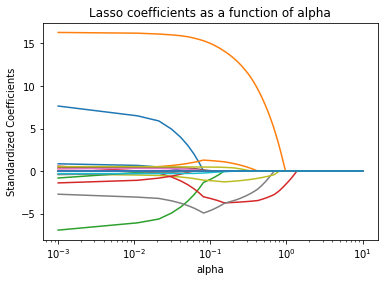

In [27]:
# see how mse changes as alpha changes 
alphas = np.linspace(0.001,10,1000)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha')

In [28]:
# then we need to find optimal alpha for lasso
# Lasso with 5 fold cross-validation
model = LassoCV(alphas = alphas, cv=5, random_state=77, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

# optimal alpha
model.alpha_

0.001

(0.00063095734448019363,
 15.848931924611133,
 35.758305820678892,
 71.392511662198444)

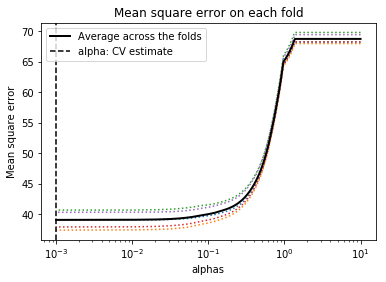

In [29]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")


In [30]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [31]:
# Training data
pred_train = lasso_best.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))
# Test data
pred = lasso_best.predict(X_test)
mse_test = mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 39.0
MSE test set 38.1


In [32]:
lasso_met = pd.DataFrame([{'training_mse':mse_train,'test_mse':mse_test}],index = ['Lasso'])

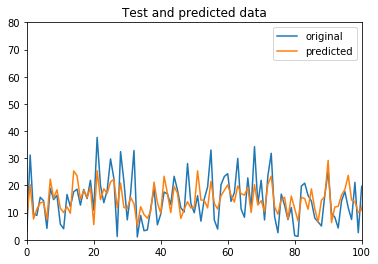

In [33]:
fig1 = plt.figure()
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, pred, label="predicted")
plt.title("Test and predicted data")
plt.xlim(0, 100)
plt.ylim(0,80)
plt.legend()
plt.show()

### KNN

In [34]:
# Determine the optimal number of neighbors
neighbors = np.arange(1, 30)
train_mse = np.empty(len(neighbors))
test_mse = np.empty(len(neighbors))
 
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsRegressor(n_jobs=-1, n_neighbors=k)
    knn.fit(X_train, y_train)
     
    # Compute training and test data MSE
    train_mse[i] = mean_squared_error(y_train, knn.predict(X_train))
    test_mse[i] = mean_squared_error(y_test, knn.predict(X_test))

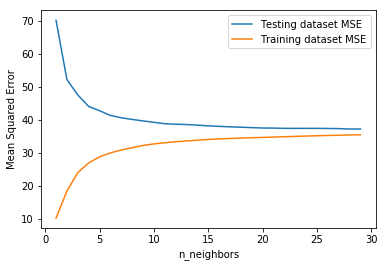

In [35]:
# plot the 'mse ~ number of neighbors' plot  
plt.plot(neighbors, test_mse, label = 'Testing dataset MSE')
plt.plot(neighbors, train_mse, label = 'Training dataset MSE')
 
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Mean Squared Error')
plt.show()

From the plot, we can see that the test set MSE stops decreasing after around n_neighbors = 15. So, we pick 15 neighbors.

In [36]:
# instantiate
knn_model = KNeighborsRegressor(n_jobs=-1, n_neighbors=15)
# fit model
knn_model.fit(X_train, y_train)
# get mse
# Training data
pred_train = knn_model.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))
# Test data
pred = knn_model.predict(X_test)
mse_test = mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 34.03
MSE test set 38.16


In [37]:
knn_met = pd.DataFrame([{'training_mse':mse_train,'test_mse':mse_test}],index = ['KNN'])

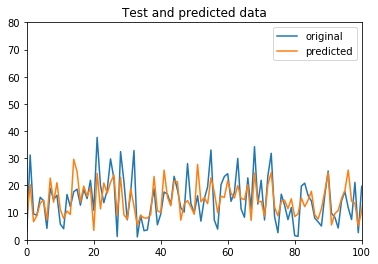

In [38]:
fig1 = plt.figure()
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, pred, label="predicted")
plt.title("Test and predicted data")
plt.xlim(0, 100)
plt.ylim(0,80)
plt.legend()
plt.show()

### Random forest

In [39]:
rf_regressor = RandomForestRegressor()
# train
rf_regressor.fit(X_train, y_train)
# metric: mse
# Training data
pred_train = rf_regressor.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))
# Test data
pred = rf_regressor.predict(X_test)
mse_test = mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 11.23
MSE test set 45.46


#### Model tuning

In [40]:
# Number of trees in random forest
n_estimators = [100, 300, 500, 800, 1200, 1500, 2000]
# Maximum number of levels in tree
max_depth = [2,4,6,8,10,15,20]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 30, 50]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'max_features': max_features,
               'bootstrap': bootstrap}

In [41]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_base = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 30 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=77, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] n_estimators=500, min_samples_split=10, max_features=sqrt, max_depth=8, bootstrap=False 
[CV]  n_estimators=500, min_samples_split=10, max_features=sqrt, max_depth=8, bootstrap=False, total=   4.5s
[CV] n_estimators=500, min_samples_split=10, max_features=sqrt, max_depth=8, bootstrap=False 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV]  n_estimators=500, min_samples_split=10, max_features=sqrt, max_depth=8, bootstrap=False, total=   4.7s
[CV] n_estimators=500, min_samples_split=10, max_features=sqrt, max_depth=8, bootstrap=False 
[CV]  n_estimators=500, min_samples_split=10, max_features=sqrt, max_depth=8, bootstrap=False, total=   4.5s
[CV] n_estimators=300, min_samples_split=30, max_features=sqrt, max_depth=2, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=30, max_features=sqrt, max_depth=2, bootstrap=True, total=   1.0s
[CV] n_estimators=300, min_samples_split=30, max_features=sqrt, max_depth=2, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=30, max_features=sqrt, max_depth=2, bootstrap=True, total=   1.0s
[CV] n_estimators=300, min_samples_split=30, max_features=sqrt, max_depth=2, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=30, max_features=sqrt, max_depth=2, bootstrap=True, total=   1.0s
[CV] n_estimators=1500, min_samples_split=10, max_features=auto, max_depth=10, bootst

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 26.3min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=30, n_jobs=-1,
          param_distributions={'n_estimators': [100, 300, 500, 800, 1200, 1500, 2000], 'max_depth': [2, 4, 6, 8, 10, 15, 20], 'min_samples_split': [2, 5, 10, 15, 20, 30, 50], 'max_features': ['auto', 'sqrt'], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=77, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [42]:
# best params
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 20,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [47]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [8, 10, 12],
    'min_samples_split': [15, 20, 25],
    'n_estimators': [600, 800, 1000]
}
# Create a based model
rf_base = RandomForestRegressor(max_features = 'auto', bootstrap = True)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_base, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [48]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] max_depth=8, min_samples_split=15, n_estimators=600 .............
[CV]  max_depth=8, min_samples_split=15, n_estimators=600, total=  13.3s
[CV] max_depth=8, min_samples_split=15, n_estimators=600 .............


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.0s remaining:    0.0s


[CV]  max_depth=8, min_samples_split=15, n_estimators=600, total=  13.4s
[CV] max_depth=8, min_samples_split=15, n_estimators=600 .............
[CV]  max_depth=8, min_samples_split=15, n_estimators=600, total=  13.0s
[CV] max_depth=8, min_samples_split=15, n_estimators=800 .............
[CV]  max_depth=8, min_samples_split=15, n_estimators=800, total=  17.5s
[CV] max_depth=8, min_samples_split=15, n_estimators=800 .............
[CV]  max_depth=8, min_samples_split=15, n_estimators=800, total=  17.7s
[CV] max_depth=8, min_samples_split=15, n_estimators=800 .............
[CV]  max_depth=8, min_samples_split=15, n_estimators=800, total=  17.7s
[CV] max_depth=8, min_samples_split=15, n_estimators=1000 ............
[CV]  max_depth=8, min_samples_split=15, n_estimators=1000, total=  22.0s
[CV] max_depth=8, min_samples_split=15, n_estimators=1000 ............
[CV]  max_depth=8, min_samples_split=15, n_estimators=1000, total=  22.1s
[CV] max_depth=8, min_samples_split=15, n_estimators=1000 ...

[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 29.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [8, 10, 12], 'min_samples_split': [15, 20, 25], 'n_estimators': [600, 800, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [49]:
grid_search.best_params_

{'max_depth': 8, 'min_samples_split': 25, 'n_estimators': 1000}

In [50]:
# best model
rf_opt = grid_search.best_estimator_
rf_opt.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=25,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [51]:
# metric: mse
# Training data
pred_train = rf_opt.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))
# Test data
pred = rf_opt.predict(X_test)
mse_test = mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 34.46
MSE test set 35.66


In [52]:
rf_met = pd.DataFrame([{'training_mse':mse_train,'test_mse':mse_test}],index = ['Random Forest'])

### Prediction Conclusion

From the output, we can see that random forest has overall best performance. 

In [53]:
pd.concat([rf_met, knn_met, lasso_met], axis = 0)

,test_mse,training_mse
Random Forest,35.656213,34.462826
KNN,38.161361,34.030821
Lasso,38.095220,39.001854
